In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error
from util import evaluate, plot_importance, plot_history

EARLY_STOPPING_ROUNDS = 10
MAX_EVALS = 200

In [2]:
def score(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train_pct_change,
              eval_set=[(X_train, y_train_pct_change), (X_valid, y_valid_pct_change)],
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              verbose=False)
    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid_pct_change, y_pred)
    return {"loss": score, "status": "ok"}

# y_train.shift()*(1 + y_train.pct_change())  # gives you back y_train raw, can substitute prediction here

In [3]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")["target"]
X_valid = pd.read_parquet("./modelling_data/X_validation.parquet")
y_valid = pd.read_parquet("./modelling_data/y_validation.parquet")["target"]

In [4]:
X_train = X_train.pct_change()[1:]
y_train_pct_change = y_train.pct_change()[1:]
X_valid = X_valid.pct_change()[1:]
y_valid_pct_change = y_valid.pct_change()[1:]

In [5]:
param_space = {
    "max_depth": hp.choice("max_depth", np.linspace(2, 10, 9, dtype=int)),
    "gamma": hp.choice("gamma", np.linspace(0, 5, 11)),
    "n_estimators": hp.choice("n_estimators", np.linspace(10, 400, 40, dtype=int)),
    "colsample_bytree": hp.choice("colsample_bytree", np.linspace(0.5, 1, 6)),
    "subsample": hp.quniform("subsample", 0.5, 1.0, 0.1),
    "eta": hp.uniform("eta", 0.05, 0.4),
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 0
}

In [6]:
trials = Trials()
best_params_loc = fmin(score, param_space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=trials)
optimal_params = space_eval(param_space, best_params_loc)

100%|██████████| 200/200 [05:21<00:00,  1.61s/trial, best loss: 0.004192169018922063]


In [7]:
optimal_params

{'colsample_bytree': 0.9,
 'eta': 0.07461024707582171,
 'eval_metric': 'rmse',
 'gamma': 0.0,
 'max_depth': 5,
 'n_estimators': 110,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'subsample': 1.0}

In [8]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")["target"]
X_valid = pd.read_parquet("./modelling_data/X_validation.parquet")
y_valid = pd.read_parquet("./modelling_data/y_validation.parquet")["target"]
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")["target"]

X_train = pd.concat([X_train, X_valid]).pct_change()[1:]
y_train_pct_change = pd.concat([y_train, y_valid]).pct_change()[1:]
X_test = pd.read_parquet("./modelling_data/X_test.parquet").pct_change()[1:]
y_test_pct_change = pd.read_parquet("./modelling_data/y_test.parquet")["target"].pct_change()[1:]

In [9]:
model = xgb.XGBRegressor(**optimal_params)
model.fit(
    X_train, y_train_pct_change,
    eval_set=[(X_train, y_train_pct_change), (X_test, y_test_pct_change)],
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    verbose=True
)

[0]	validation_0-rmse:0.46548	validation_1-rmse:0.46537
[1]	validation_0-rmse:0.43146	validation_1-rmse:0.43138
[2]	validation_0-rmse:0.40003	validation_1-rmse:0.39992
[3]	validation_0-rmse:0.37100	validation_1-rmse:0.37087
[4]	validation_0-rmse:0.34419	validation_1-rmse:0.34413
[5]	validation_0-rmse:0.31944	validation_1-rmse:0.31941
[6]	validation_0-rmse:0.29660	validation_1-rmse:0.29660
[7]	validation_0-rmse:0.27554	validation_1-rmse:0.27557
[8]	validation_0-rmse:0.25612	validation_1-rmse:0.25616
[9]	validation_0-rmse:0.23824	validation_1-rmse:0.23830
[10]	validation_0-rmse:0.22176	validation_1-rmse:0.22185
[11]	validation_0-rmse:0.20661	validation_1-rmse:0.20673
[12]	validation_0-rmse:0.19268	validation_1-rmse:0.19285
[13]	validation_0-rmse:0.17990	validation_1-rmse:0.18012
[14]	validation_0-rmse:0.16816	validation_1-rmse:0.16846
[15]	validation_0-rmse:0.15741	validation_1-rmse:0.15774
[16]	validation_0-rmse:0.14757	validation_1-rmse:0.14797
[17]	validation_0-rmse:0.13858	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.07461024707582171,
             eval_metric='rmse', gamma=0.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0746102482,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=110, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1.0, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [10]:
y_pred_pct_change = model.predict(X_test)
y_pred = y_test.shift()[1:]*(1 + y_pred_pct_change)

MAE = 4.5144006746919185
MSE = 65.31455159784414
RMSE = 8.081741866568379
MAPE = 0.035100760459357706
R^2 = 0.7088713517658554
Explained Variance Score = 0.7107347102606647

Residuals summary stats
╒═══════╤═══════════╕
│ count │     14533 │
├───────┼───────────┤
│ mean  │  0.646563 │
├───────┼───────────┤
│ std   │   8.05611 │
├───────┼───────────┤
│ min   │  -50.4749 │
├───────┼───────────┤
│ 25%   │  -1.57497 │
├───────┼───────────┤
│ 50%   │ 0.0867685 │
├───────┼───────────┤
│ 75%   │   2.33214 │
├───────┼───────────┤
│ max   │   63.9373 │
╘═══════╧═══════════╛

Deviation from mean of residuals
╒════════════╤══════════╤════════════╕
│ Interval   │   Actual │   Expected │
╞════════════╪══════════╪════════════╡
│ μ ± σ      │  83.8368 │       68.2 │
├────────────┼──────────┼────────────┤
│ μ ± 2σ     │  92.7407 │       95.4 │
├────────────┼──────────┼────────────┤
│ μ ± 3σ     │  97.1995 │       99.7 │
╘════════════╧══════════╧════════════╛

Jarque-Bera Test on Residuals
╒═══════════

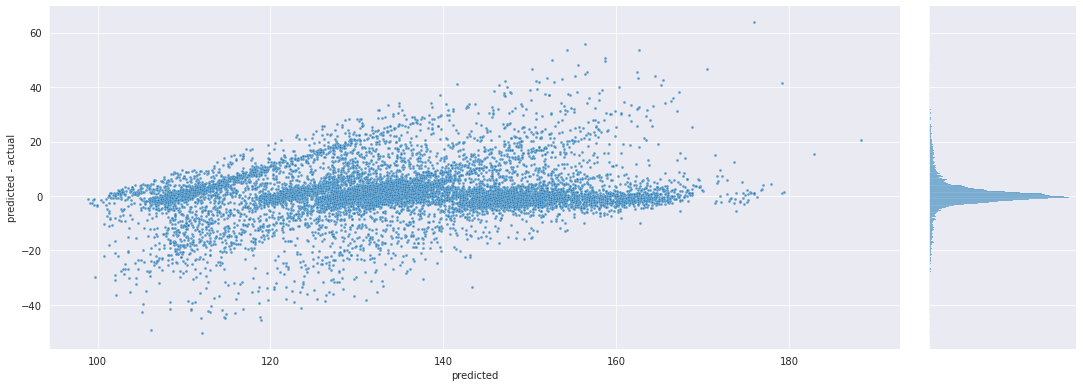

<Figure size 720x576 with 0 Axes>

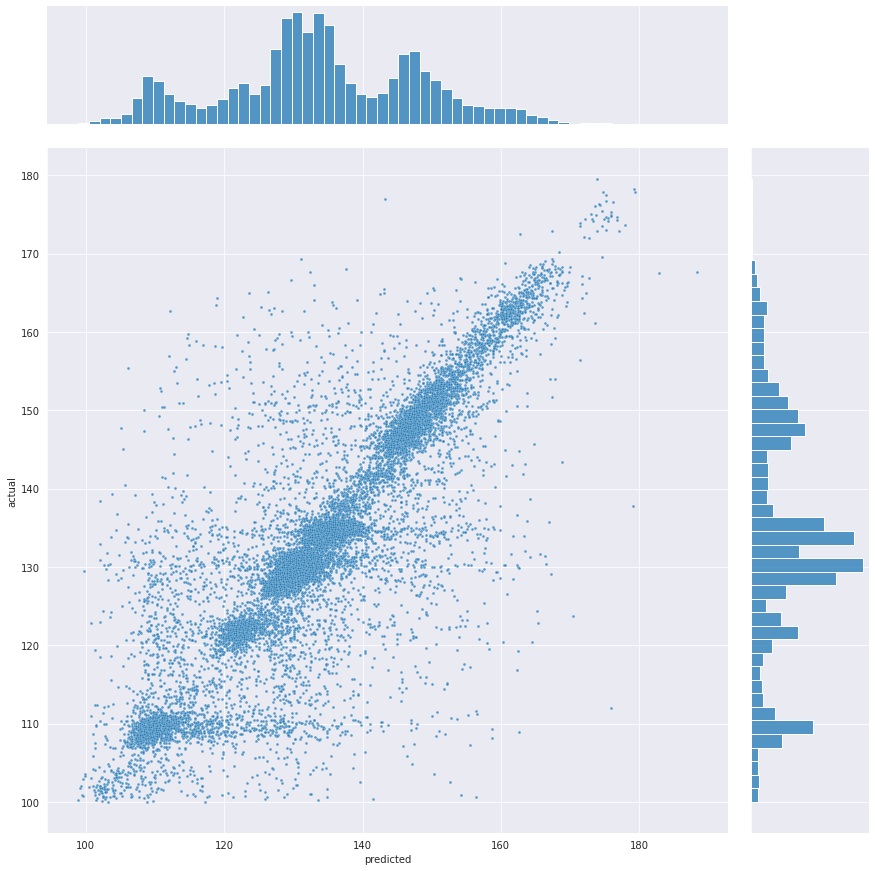

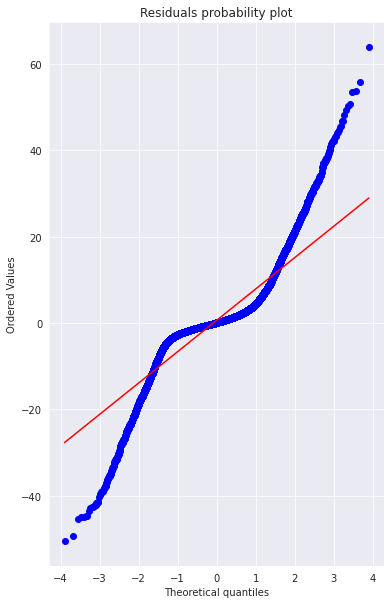

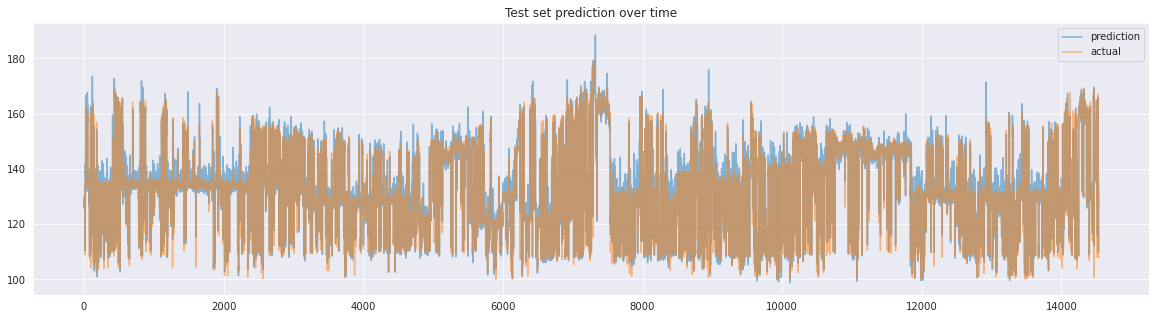

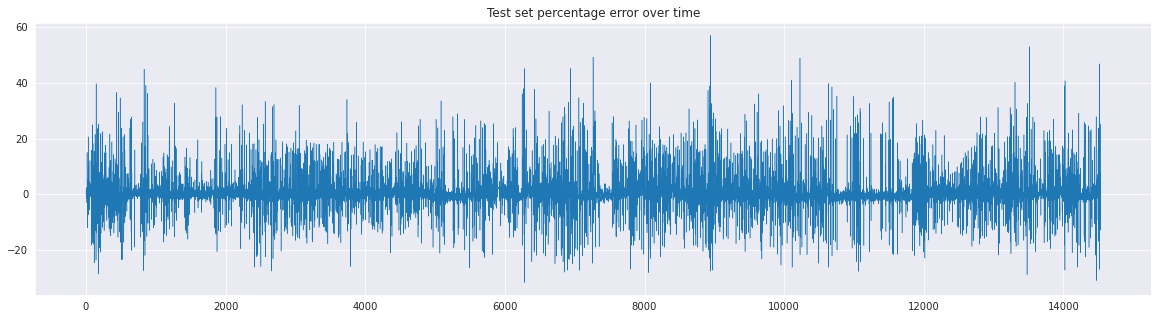

In [11]:
evaluate(y_test[1:].to_numpy(), y_pred.to_numpy())

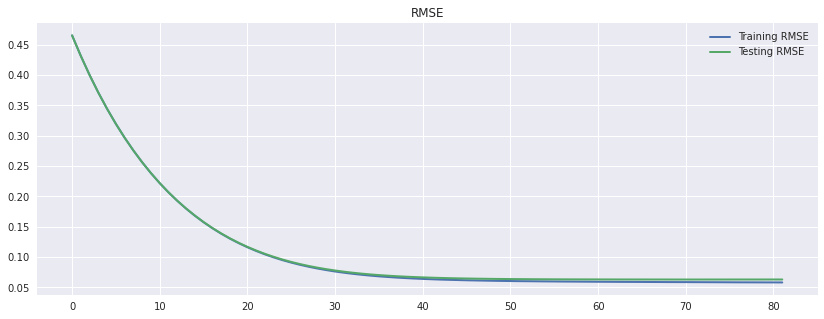

In [12]:
plot_history(model)

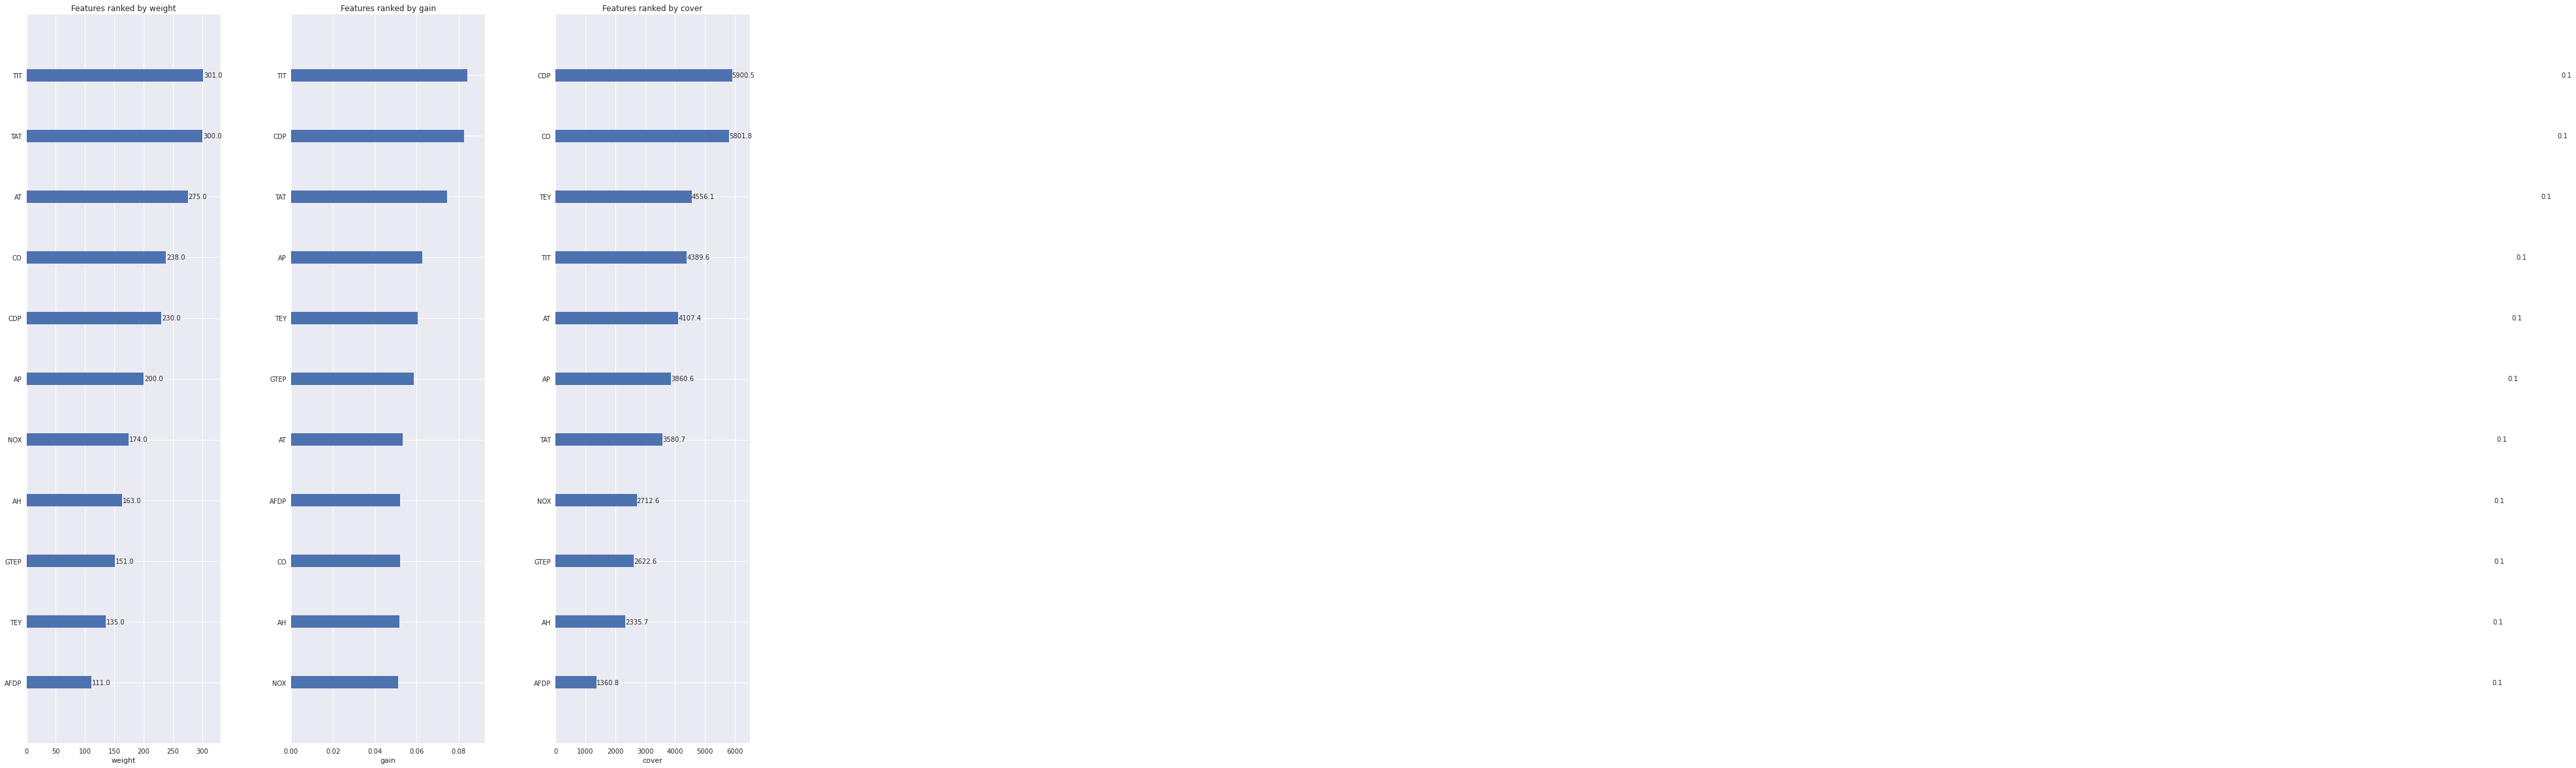

In [13]:
plot_importance(model)